In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from pytorch_sklearn.neural_network.neural_network import NeuralNetwork
from pytorch_sklearn.neural_network.generative_network import CycleGAN
from pytorch_sklearn.callbacks.predefined import Verbose, History, EarlyStopping
from pytorch_sklearn.utils.progress_bar import print_progress

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.conv3(x)
    
class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super(SimpleDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=4)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=4)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = F.relu(self.maxpool1(self.conv1(x)))
        x = F.relu(self.maxpool2(self.conv2(x)))
        x = self.maxpool3(self.conv3(x))
        return x.view(-1, 1)

In [3]:
model = SimpleDiscriminator()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
crit = nn.MSELoss()

In [4]:
X = torch.randn(10, 3, 32, 32)
y = torch.randn(10, 1)

In [5]:
net = NeuralNetwork(model, optim, crit)

In [6]:
net.callbacks

In [7]:
net.fit(
    train_X=X,
    train_y=y,
    max_epochs=50,
    callbacks=[Verbose(notebook=True)],
    metrics={'l1loss': nn.L1Loss(), 'l2loss': nn.MSELoss()},
)

Epoch 1/50
1/1 [====================] - train_loss: 0.979 - train_l1loss: 0.688 - train_l2loss: 0.979 - Time: 0.34 - ETA: 0.00
Epoch 2/50
1/1 [====================] - train_loss: 0.716 - train_l1loss: 0.641 - train_l2loss: 0.716 - Time: 0.00 - ETA: 0.00
Epoch 3/50
1/1 [====================] - train_loss: 0.728 - train_l1loss: 0.716 - train_l2loss: 0.728 - Time: 0.00 - ETA: 0.00
Epoch 4/50
1/1 [====================] - train_loss: 0.722 - train_l1loss: 0.734 - train_l2loss: 0.722 - Time: 0.00 - ETA: 0.00
Epoch 5/50
1/1 [====================] - train_loss: 0.643 - train_l1loss: 0.673 - train_l2loss: 0.643 - Time: 0.00 - ETA: 0.00
Epoch 6/50
1/1 [====================] - train_loss: 0.563 - train_l1loss: 0.600 - train_l2loss: 0.563 - Time: 0.00 - ETA: 0.00
Epoch 7/50
1/1 [====================] - train_loss: 0.526 - train_l1loss: 0.552 - train_l2loss: 0.526 - Time: 0.00 - ETA: 0.00
Epoch 8/50
1/1 [====================] - train_loss: 0.514 - train_l1loss: 0.535 - train_l2loss: 0.514 - Time: 0

In [8]:
net.predict(X)

tensor([[-0.2895],
        [ 0.6550],
        [ 0.6346],
        [ 1.6697],
        [ 0.1107],
        [ 0.9337],
        [-0.1415],
        [ 2.7859],
        [ 0.2574],
        [-0.2391]], device='cuda:0')

In [9]:
class CycleGANDataset(Dataset):
    def __init__(self):
        self.A = torch.randn(10, 3, 32, 32) * .1
        self.B = torch.randn(10, 3, 32, 32) * .8

    def __len__(self):
        return 10
    
    def __getitem__(self, index):
        return self.A[index], self.B[index]

In [10]:
class STDMetric:
    def __init__(self):
        self.stdA = []
        self.stdB = []
        self.stdA2B = []
        self.stdB2A = []

    def __call__(self, batch_out, batch_y):
        A2B, B2A = batch_out
        A, B = batch_y
        self.stdA.append(A.std().item())
        self.stdB.append(B.std().item())
        self.stdA2B.append(A2B.std().item())
        self.stdB2A.append(B2A.std().item())
        return 0

In [11]:
G_A = SimpleCNN()
G_B = SimpleCNN()
D_A = SimpleDiscriminator()
D_B = SimpleDiscriminator()

G_optim = torch.optim.Adam(list(G_A.parameters()) + list(G_B.parameters()), lr=0.001)
D_optim = torch.optim.Adam(list(D_A.parameters()) + list(D_B.parameters()), lr=0.001)

In [12]:
cycle_gan = CycleGAN(G_A, G_B, D_A, D_B, G_optim, D_optim)

In [13]:
cycle_gan_ds = CycleGANDataset()

In [14]:
std_metric = STDMetric()

In [23]:
cycle_gan.fit(
    train_X=cycle_gan_ds,
    max_epochs=200,
    callbacks=[Verbose(notebook=True)],
    metrics={'std': std_metric},
)

Epoch 401/600
1/1 [====================] - train_loss: 1.454 - train_std: 2.814 - Time: 0.15 - ETA: 0.00
Epoch 402/600
1/1 [====================] - train_loss: 1.463 - train_std: 2.809 - Time: 0.11 - ETA: 0.00
Epoch 403/600
1/1 [====================] - train_loss: 1.446 - train_std: 2.827 - Time: 0.04 - ETA: 0.00
Epoch 404/600
1/1 [====================] - train_loss: 1.462 - train_std: 2.855 - Time: 0.03 - ETA: 0.00
Epoch 405/600
1/1 [====================] - train_loss: 1.446 - train_std: 2.921 - Time: 0.03 - ETA: 0.00
Epoch 406/600
1/1 [====================] - train_loss: 1.465 - train_std: 2.864 - Time: 0.02 - ETA: 0.00
Epoch 407/600
1/1 [====================] - train_loss: 1.449 - train_std: 2.819 - Time: 0.03 - ETA: 0.00
Epoch 408/600
1/1 [====================] - train_loss: 1.456 - train_std: 2.790 - Time: 0.03 - ETA: 0.00
Epoch 409/600
1/1 [====================] - train_loss: 1.447 - train_std: 2.795 - Time: 0.04 - ETA: 0.00
Epoch 410/600
1/1 [====================] - train_loss: 

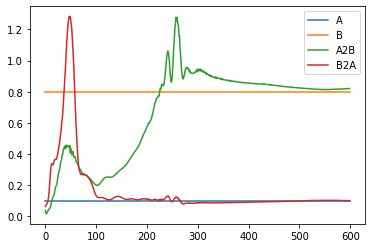

In [24]:
plt.plot(std_metric.stdA, label='A')
plt.plot(std_metric.stdB, label='B')
plt.plot(std_metric.stdA2B, label='A2B')
plt.plot(std_metric.stdB2A, label='B2A')
plt.legend()
plt.show()

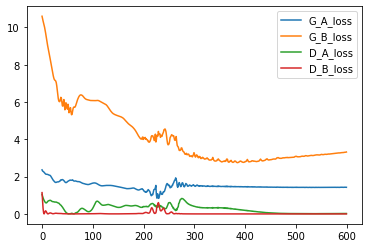

In [25]:
plt.plot(cycle_gan.history.track['train_G_A_loss'], label='G_A_loss')
plt.plot(cycle_gan.history.track['train_G_B_loss'], label='G_B_loss')
plt.plot(cycle_gan.history.track['train_D_A_loss'], label='D_A_loss')
plt.plot(cycle_gan.history.track['train_D_B_loss'], label='D_B_loss')
plt.legend()
plt.show()

In [26]:
cycle_gan.predict(cycle_gan_ds[0][0])

AttributeError: 'CycleGAN' object has no attribute 'module'

In [18]:
from typing import Iterable, Tuple, List, Sequence

In [19]:
a = []
for i in range(5):
    a.append([1,2])

In [20]:
np.stack(a)

array([[1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2]])

In [31]:
a = []
a.append([1,2,3])
a.append([1,2,3])
a.append([1,2,3])
a.append([1,2,3])
np.concatenate(a)

array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3])